In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

import string
import math
import missingno as mso
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve,roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

In [ ]:
songs_df = pd.read_csv('/content/songs.csv')
songs_extra = pd.read_csv('/content/song_extra_info.csv')
members = pd.read_csv('/content/members.csv')
train = pd.read_csv('/content/train.csv', nrows = 100000)

In [ ]:
songs_extra.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [ ]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [ ]:
merge_1 = pd.merge(train, songs_df, on = 'song_id', how = 'left')
merge_2 = pd.merge(merge_1, songs_extra, on = 'song_id', how = 'left')
songs = pd.merge(merge_2, members, on = 'msno', how = 'left')
del train, songs_df, songs_extra, members, merge_1, merge_2
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,NaN,NaN,NaN,NaN,NaN,NaN,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,NaN,NaN,NaN,NaN,NaN,NaN,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


In [ ]:
songs.shape

(100000, 20)

In [ ]:
songs.isnull().sum()

msno                          0
song_id                       0
source_system_tab           303
source_screen_name         4273
source_type                 195
target                        0
song_length               18504
genre_ids                 19805
artist_name               18504
composer                  36000
lyricist                  51785
language                  18504
name                      14692
isrc                      21987
city                          0
bd                            0
gender                    38672
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

<Axes: >

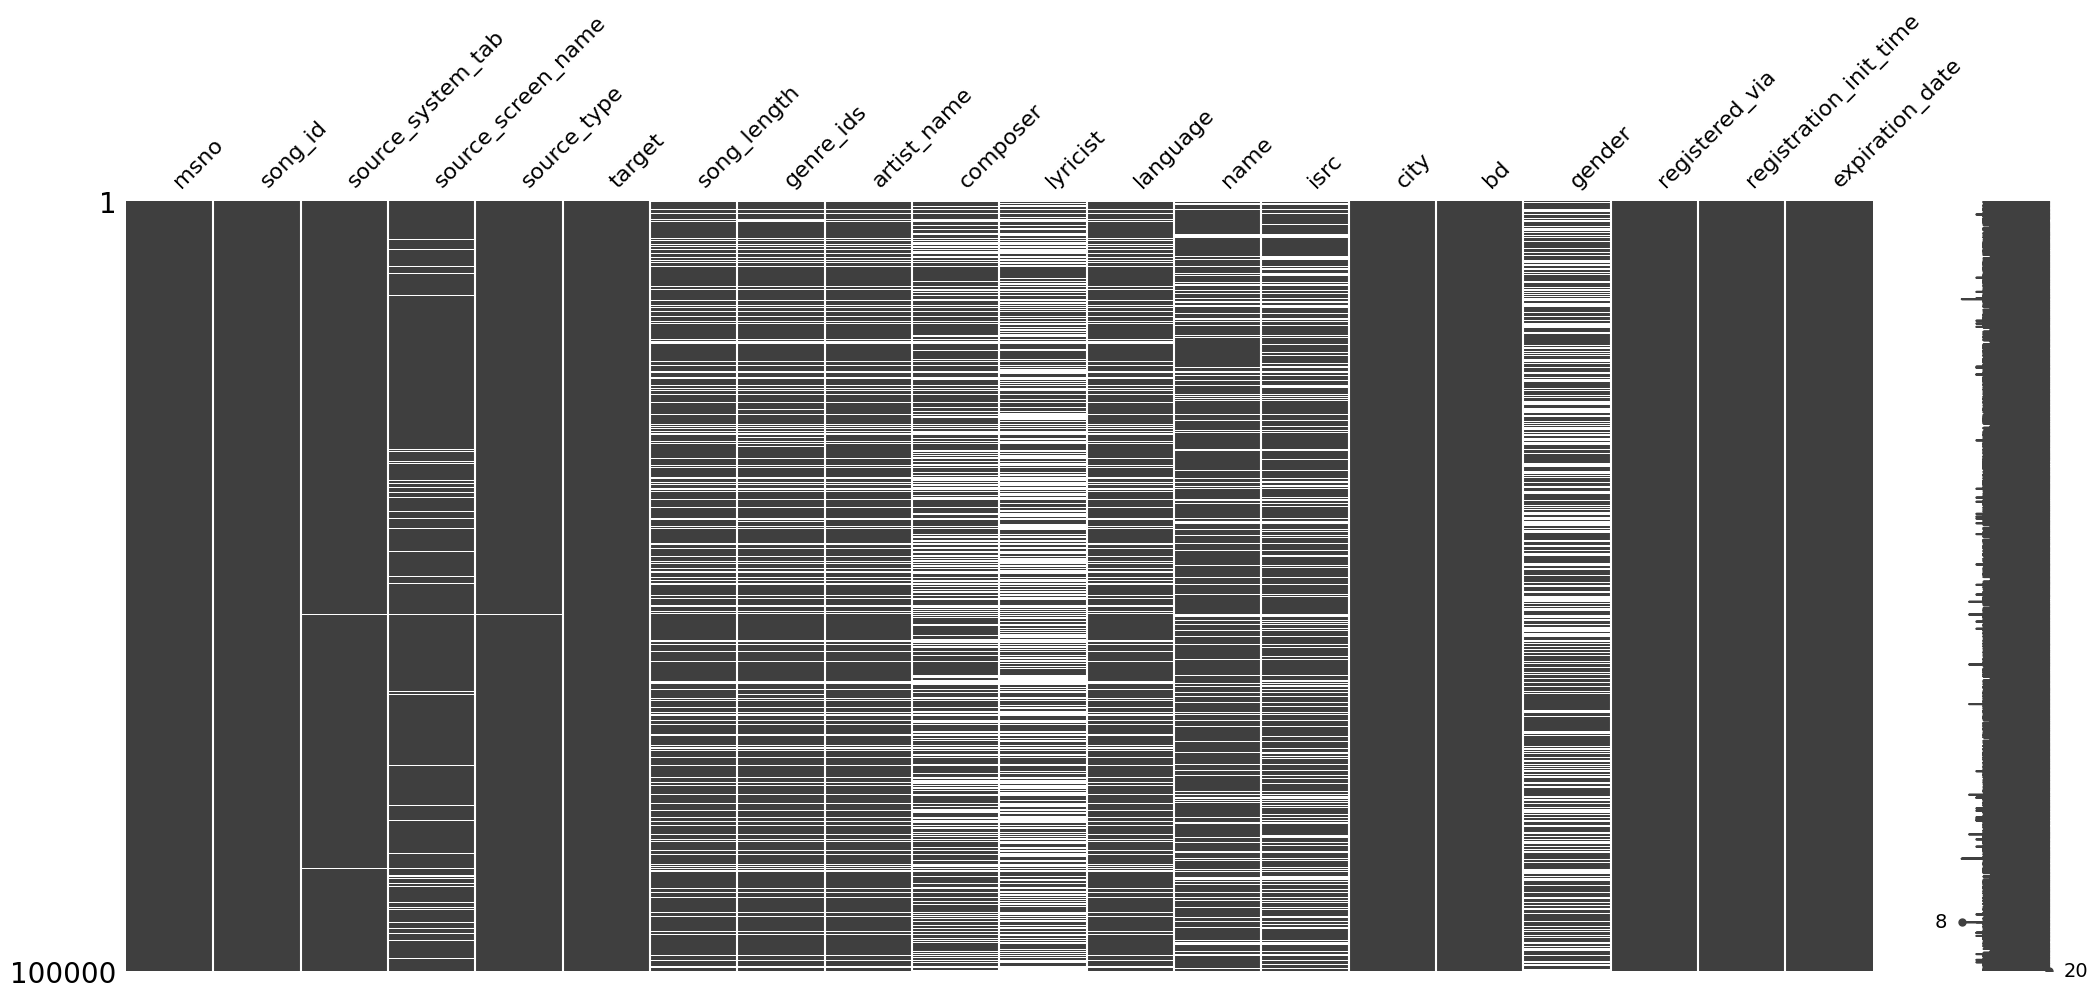

In [ ]:
mso.matrix(songs)

In [ ]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs.fillna(value = 0).tail()


,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
99995,EedNarOVNUU5ppYW/ho+KV8V29zuf7m3+Df5qnQ9FT4=,c7bvJHblBfQGFJG+DcltwclubmlYvIRTT964Lu4WWXI=,my library,Local playlist more,local-playlist,1,236982.0,465,2NE1,unknown,unknown,31.0,I Love You,TWA531200396,14,0,unknown,9,20150321,20170923
99996,xyxz9lf8ipoxELeDLlazmHVZHE1ZYqE6iwfJWkH3Ojc=,MZTwICqr12ijCeBaWeKVJZ67Bz7NI0WA4bqB1IwR4jI=,my library,Local playlist more,local-library,0,0.0,unknown,unknown,unknown,unknown,0.0,unknown,unknown,1,0,unknown,7,20120117,20171004
99997,vDi/nHqBu7wb+DtI2Ix4TupWQatUEFR41mDC0c8Voh8=,xK0clTH8TvjG6sKmJXZuMLzhikhlEsolLtx2AHBpmbQ=,my library,Local playlist more,local-library,1,196812.0,465,Michael Giacchino,Mikkel Eriksen|Sia Furler|Tor Erik Hermansen,unknown,52.0,Try Everything,USWD11575402,13,0,unknown,9,20110322,20180403
99998,xyxz9lf8ipoxELeDLlazmHVZHE1ZYqE6iwfJWkH3Ojc=,SoPkcfpiBjDpZSNPN3HdbPI8WAkuenayPXyBRK91T2s=,my library,Local playlist more,local-library,0,0.0,unknown,unknown,unknown,unknown,0.0,Dark Horse,USUM71311296,1,0,unknown,7,20120117,20171004
99999,n8TgRhOBw+DthR6N6ie/63yp3KHA20UVHlbK9nY9nIc=,PEEg0ODi9cPg1VXM9EOhZtV39sBJFr/9cIflhbHJ5Bs=,my library,Local playlist more,local-library,1,191425.0,465,孫盛希 (Shi Shi),孫盛希,孫盛希,3.0,unknown,unknown,1,0,unknown,7,20150706,20170921


<Axes: >

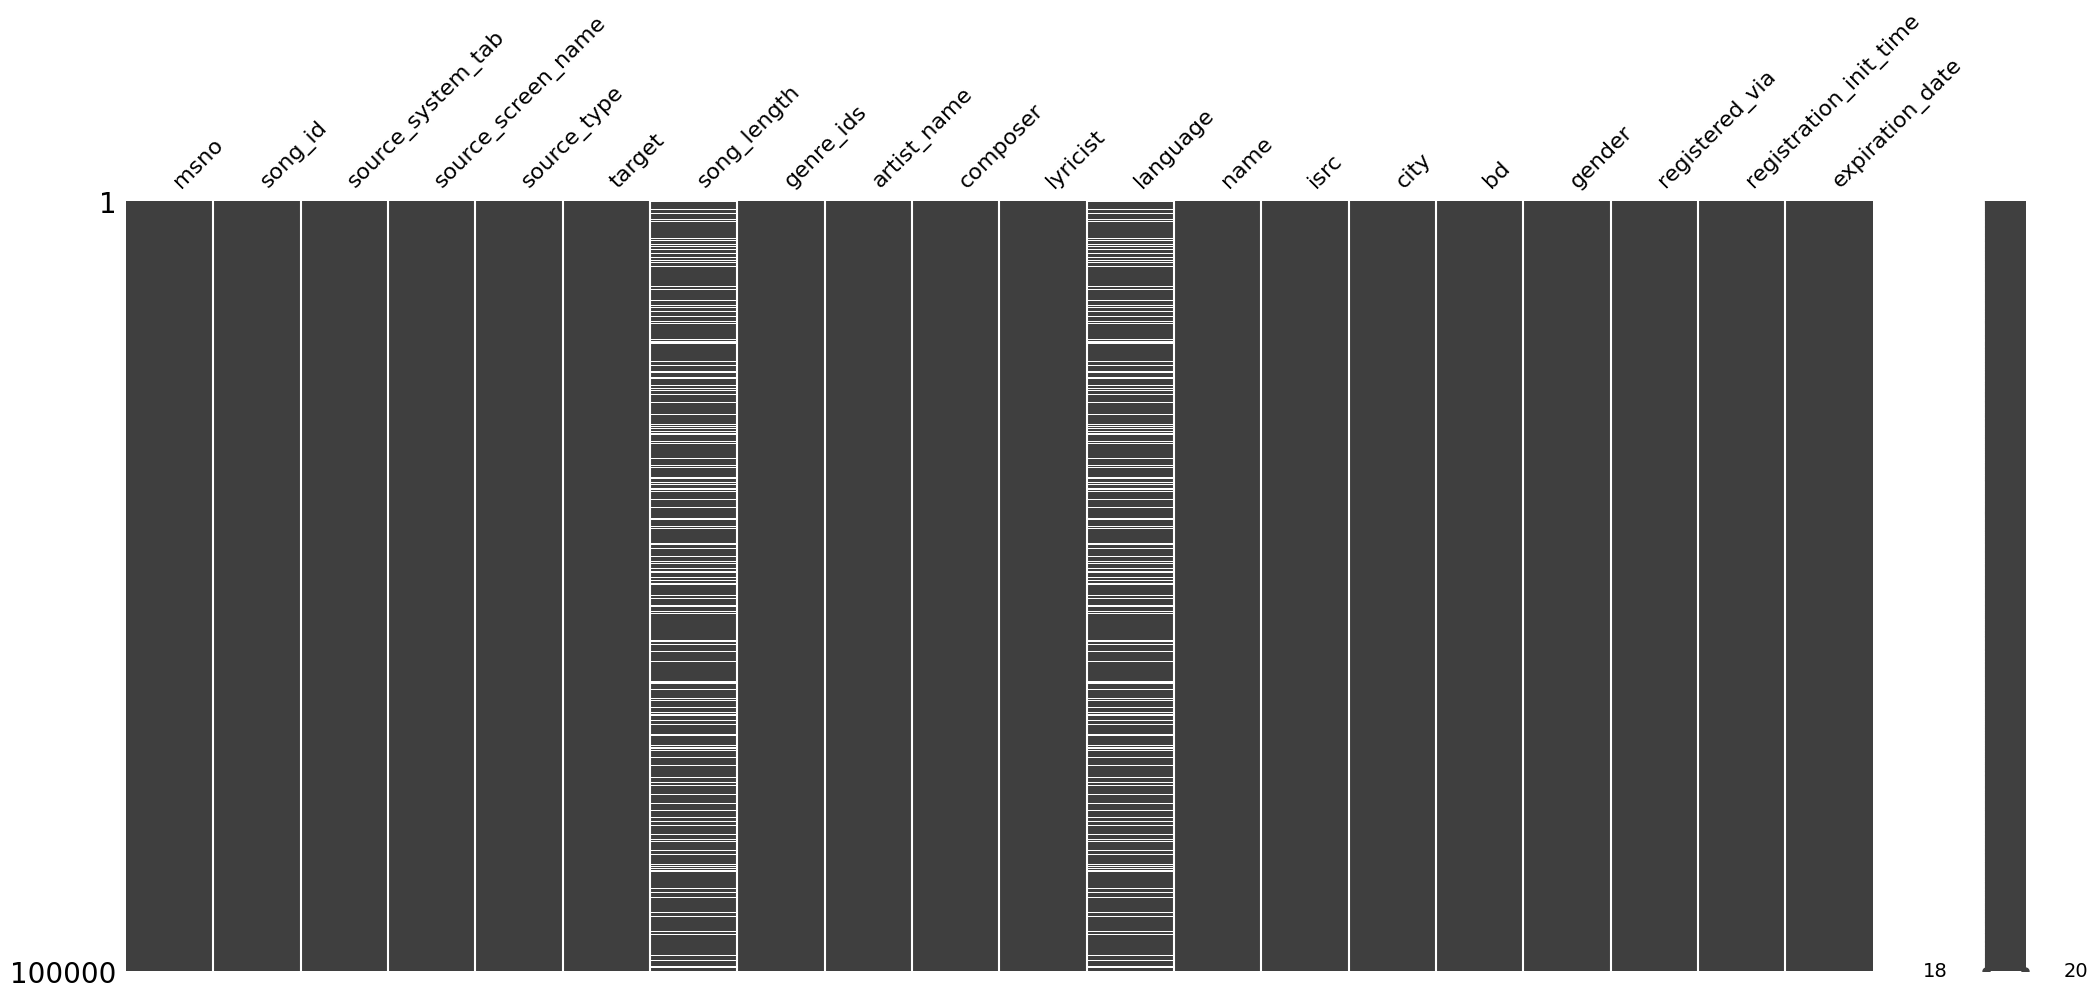

In [ ]:
mso.matrix(songs)

In [ ]:
songs.registration_init_time = pd.to_datetime(songs.registration_init_time, format='%Y%m%d', errors='ignore')
songs['registration_init_time_year'] = songs['registration_init_time'].dt.year
songs['registration_init_time_month'] = songs['registration_init_time'].dt.month
songs['registration_init_time_day'] = songs['registration_init_time'].dt.day

songs.expiration_date = pd.to_datetime(songs.expiration_date,  format='%Y%m%d', errors='ignore')
songs['expiration_date_year'] = songs['expiration_date'].dt.year
songs['expiration_date_month'] = songs['expiration_date'].dt.month
songs['expiration_date_day'] = songs['expiration_date'].dt.day

In [ ]:
songs.head()


,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,NaN,unknown,unknown,unknown,unknown,NaN,Good Grief,GBUM71602854,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,NaN,unknown,unknown,unknown,unknown,NaN,unknown,unknown,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,unknown,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,NaN,unknown,unknown,unknown,unknown,NaN,Disco Africa,GBUQH1000063,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,unknown,52.0,Sleep Without You,QM3E21606003,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [ ]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoder.fit_transform(songs[i])

In [ ]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,1647,6022,1,6,5,1,10216,179,3420,6402,2666,10,3334,2739,0,1,2,2,1176,328,8,0,1,4,9,4
1,3471,18027,3,7,4,1,10216,179,3420,6402,2666,10,10669,20108,11,14,0,3,974,304,7,4,24,4,8,10
2,3471,9744,3,7,4,1,4301,24,2154,4278,2666,8,3725,18733,11,14,0,3,974,304,7,4,24,4,8,10
3,3471,1868,3,7,4,1,10216,179,3420,6402,2666,10,2290,2765,11,14,0,3,974,304,7,4,24,4,8,10
4,1647,2688,1,6,5,1,1945,0,461,813,2666,8,7957,7424,0,1,2,2,1176,328,8,0,1,4,9,4


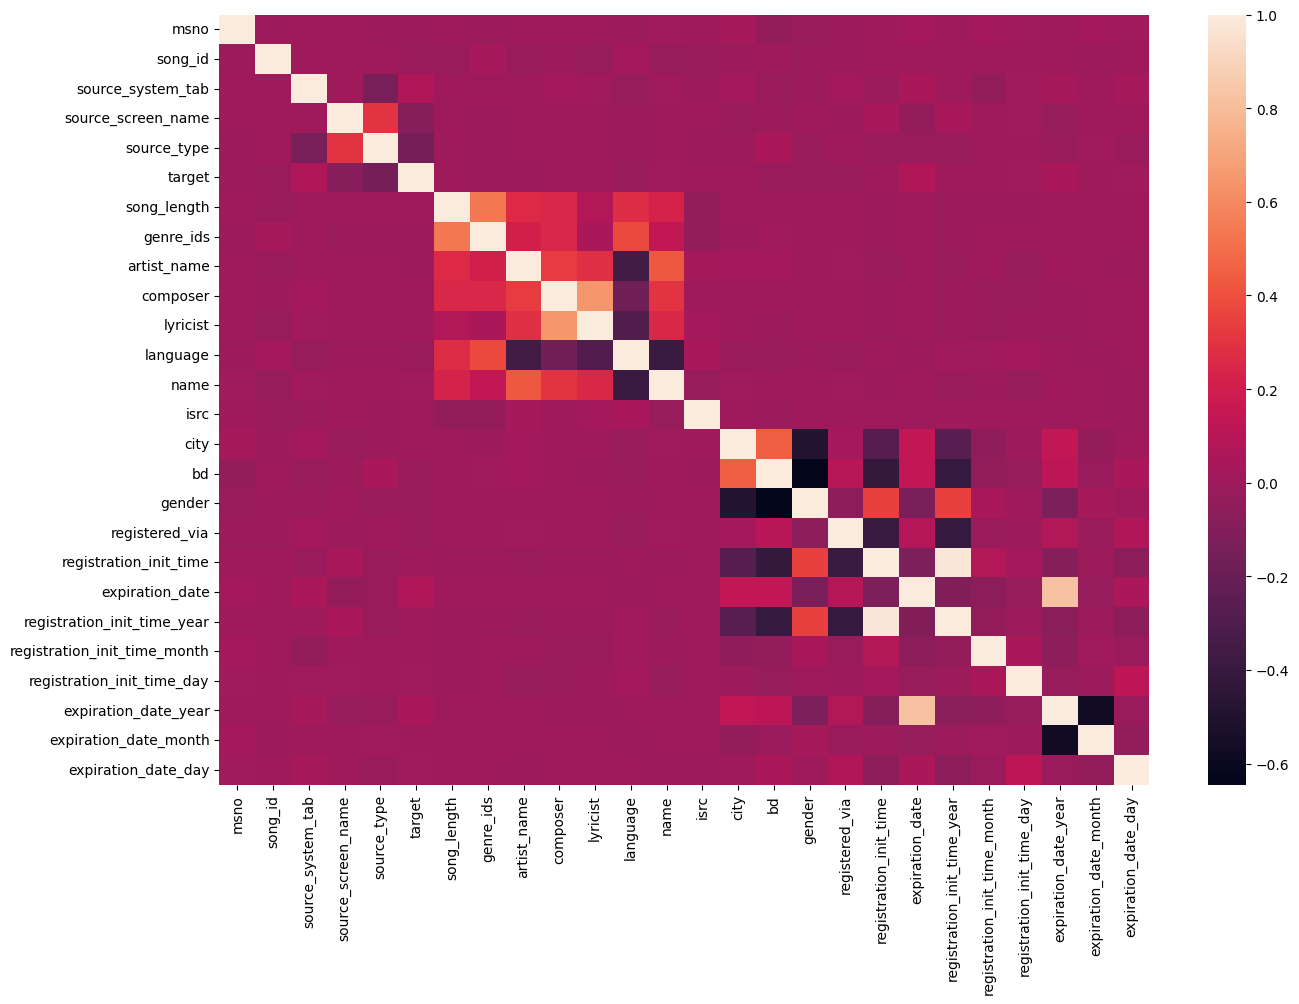

In [ ]:
plt.figure(figsize=[15,10])
sns.heatmap(songs.corr()) #annot = True
plt.show()

In [ ]:
songs.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'name', 'isrc', 'city', 'bd',
       'gender', 'registered_via', 'registration_init_time', 'expiration_date',
       'registration_init_time_year', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_year',
       'expiration_date_month', 'expiration_date_day'],
      dtype='object')

In [ ]:
X = songs.drop('target', axis = 1)
y = songs['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [ ]:
def model_with(model_name, X_train, X_val, y_train, y_val) :
    print("==================================================")
    print("Modeling with :", model_name)
    print()

    if model_name == "Random Forest Classifier" :
        model = RandomForestClassifier(
            n_estimators=1000,
        )
    elif model_name == "Extra Trees Classifier" :
        model = ExtraTreesClassifier(
            n_estimators=1000,
        )
    elif model_name == "LightGBM Classifier" :
        model = lgbm.LGBMClassifier(
            n_estimators=1000,
        )
    elif model_name == "XGBoost Classifier" :
        model = xgb.XGBClassifier(
            n_estimators=1000,
        )
    elif model_name == "CatBoost Classifier" :
        model = cb.CatBoostClassifier(
            n_estimators=1000,
            verbose=0
        )
    else :
        print("Model not found in function.")

    model.fit(X_train, y_train)

    val_pred = model.predict(X_val)
    print(classification_report(y_val, val_pred))
    print()
    print("Accuracy :", accuracy_score(y_val, val_pred))
    print("ROC :", roc_auc_score(y_val, val_pred))

    print("==================================================")
    print()

In [ ]:
models = ["Random Forest Classifier", "Extra Trees Classifier", "LightGBM Classifier", "XGBoost Classifier", "CatBoost Classifier"]
for i in models :
    model_with(i, X_train, X_val, y_train, y_val)

Modeling with : Random Forest Classifier

              precision    recall  f1-score   support

           0       0.75      0.57      0.65      6176
           1       0.87      0.94      0.90     18824

    accuracy                           0.85     25000
   macro avg       0.81      0.76      0.78     25000
weighted avg       0.84      0.85      0.84     25000


Accuracy : 0.84688
ROC : 0.755149142644491

Modeling with : Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.72      0.59      0.65      6176
           1       0.87      0.93      0.90     18824

    accuracy                           0.84     25000
   macro avg       0.80      0.76      0.77     25000
weighted avg       0.84      0.84      0.84     25000


Accuracy : 0.84316
ROC : 0.7577377862347482

Modeling with : LightGBM Classifier

[LightGBM] [Info] Number of positive: 56244, number of negative: 18756
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the 

In [ ]:
rf = RandomForestClassifier(
        n_estimators = 1000,
        class_weight={0: 1.0050505050505052, 1: 0.9949494949494948}
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1.0050505050505052,
                                     1: 0.9949494949494948},
                       n_estimators=1000)

In [ ]:
val_pred = rf.predict(X_val)
print("Accuracy :", accuracy_score(y_val, val_pred))

Accuracy : 0.8468


In [ ]:
rf = RandomForestClassifier(
        n_estimators = 1000
)
rf.fit(X_train, y_train)
val_pred = rf.predict(X_val)
print("Accuracy :", accuracy_score(y_val, val_pred))


In [47]:
#suvam kumar verma